# Analytical Introduction to PID controllers
#### V. Hunter Adams (vha3@cornell.edu)

In [457]:
from IPython.core.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

> - [About this document](#About-this-document)
> - [Video discussion of the content on this page](#Video-discussion-of-the-content-on-this-page)
> - [System under consideration](#System-under-consideration)
> - [Modeling the motor](#Modeling-the-motor)
> > - [Mechanical motor model](#Mechanical-motor-model)
> > - [Electrical motor model](#Electrical-motor-model)
> > - [Rewriting $V_{emf}$](#Rewriting-$V_{emf}$)
> > - [Rewriting $\tau$](#Rewriting-$\tau$)
> > - [Simplifying $K_t$ and $K_e$](#Simplifying-$K_t$-and-$K_e$)
> > - [Laplace transforms](#Laplace-transforms)
> > - [Transfer function](#Transfer-function)
> > - [Bode plot](#Bode-plot)
> > - [Step response](#Step-response)
> > - [Making some observations](#Making-some-observations)
> > - [Simplifying the motor model](#Simplifying-the-motor-model)
> - [Modeling the pendulum physics](#Modeling-the-pendulum-physics)
> > - [Thrust](#Thrust)
> > - [Gravity](#Gravity)
> > - [Friction](#Friction)
> > - [Equation of motion](#Equation-of-motion)
> > - [Linearization](#Linearization)
> > - [Laplace Transform](#Pendulum-Laplace-transform)
> > - [Transfer function](#Pendulum-transfer-function)
> > - [Bode plot](#Pendulum-Bode-plot)
> - [Open-loop transfer function](#Open-loop-transfer-function)
> > - [Open-loop observations](#Open-loop-observations)
> - [Building a PID controller](#Building-a-PID-controller)
> > - [Proportional term](#Proportional-term)
> > - [Derivative term](#Derivative-term)
> > - [Integral term](#Integral-term)
> - [Simulating the system](#Simulating-the-system)

## About this document

This document was assembled for students in ECE 4760, who are asked to construct and control a constrained drone like the one described below. I used the RP2040 for the demo videos rather than a PIC32 so that I could make use of the VGA screen for visualizations.

A separate document focuses on building a phenomenological understanding of PID controllers through demos. This document focuses on building an analytical understanding of these controllers. The hope is that the phenomenological document will help you debug your system based on the behavior that you observe in lab, and this one will help you understand that behavior.

- [Phenomenological PID page](./PID.html) (useful for debugging in lab)

## Video discussion of the content on this page

<iframe width="560" height="315" src="https://www.youtube.com/embed/MUs7AFRCSzg?start=1270" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## System under consideration

Consider the system illustrated below. There is a drone motor rigidly attached to the end of a lever arm. The other end of this lever arm is attached to a low-torque potentiometer. As the motor spins increasingly quickly ($\omega$ rad/sec), the thrust that it generates ($F_{thrust}$) exceeds the force of gravity ($F_g$) and lifts the arm to increasingly large angles $\theta$ away from the vertical. This is the system that we will build and control in ECE 4760. The user will specify a target angle, $\theta$, and a PID controller will control the motor speed to drive the arm to that angle. This document aims to systematically build an intuition for the system and for the controller that we'll use to control this system.

<figure>
    <img align="center" width="700" height="500" src="system.png" alt='missing' />
    <center><figcaption>System under consideration</figcaption></center>
</figure>

<iframe width="560" height="315" src="https://www.youtube.com/embed/vh2X8x1M284" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Modeling the motor

#### Mechanical motor model

<figure>
    <img align="center" width="700" height="500" src="mechanical.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

We can mechanically model the motor as an inertial mass spinning about a shaft. This inertial mass has some moment of inertia $J$. An external torque, $\tau$, rotates the shaft by some angle $\theta$. As the shaft rotates, it experiences drag that is proportional to its rotation speed, $b\dot{\theta}$. The net torque on the shaft produces an angular acceleration according to $\sum \tau = J\ddot{\theta}$.

\begin{align}
\tau &= \text{applied torque}\\
b &= \text{drag coefficient}\\
\theta &= \text{rotation angle}
\end{align}

All of these can be combined into the following torque-balance equation:

\begin{align}
\tau - b\dot{\theta} = J\ddot{\theta}
\end{align}

#### Electrical motor model

<figure>
    <img align="center" width="700" height="500" src="electrical.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

A motor works by placing current through a wire coil armature. This armature rests in a static magnetic field, which exerts a Lorentz force on the current-carrying armature. As the armature spins, current is also induced in the opposite direction. As such, the electrical model for a DC motor is a resistor, inductor, and back-emf voltage sorce in series.

Using Kirchoff's voltage law, we arrive at an expression which relates the voltage among all the components in the electrical model of our motor:

\begin{align}
V - Ri - L\frac{di}{dt} - V_{emf} = 0
\end{align}

#### Rewriting $V_{emf}$

Within the operating limits of the motor (i.e. not at saturation), there is an approximately linear relationship between the voltage applied to the motor ($V$) and the rotation rate ($\dot{\theta}$). The slope of this line can be established experimentally for a particular motor, but we will use some general proportionality constant $K_v$.

\begin{align}
\dot{\theta} = K_v V
\end{align}

This is an expression that gives us rotation speed as a function of applied voltage. By rearranging this equation, we can solve for $V_{emf}$, which is generated voltage as a function of motor speed:

\begin{align}
V_{emf} = \frac{1}{K_v} \dot{\theta}
\end{align}

For tidyness, we'll define $\frac{1}{K_v} \equiv K_e$, giving us the expression:

\begin{align}
V_{emf} = K_e \dot{\theta}
\end{align}

Substituting back into the electrical motor model yields:

\begin{align}
V - Ri - L\frac{di}{dt} - K_e \dot{\theta} = 0
\end{align}

#### Rewriting $\tau$

We've seen that the output speed of the motor is proportional to applied voltage. Similarly, the output torque of the motor is proportional to current through the motor. The constant of proportionality is the *torque constant* $K_t$.

\begin{align}
\tau = K_t i
\end{align}

Substituting into the mechanical motor model equation yields:

\begin{align}
K_t i - b\dot{\theta} = J\ddot{\theta}
\end{align}

#### Simplifying $K_t$ and $K_e$

Note that in SI units, $K_t = K_e$. So, we'll define some term $K \equiv K_t = K_e = \frac{1}{K_v}$. Substituting this into our electrical and mechanical models for the motor yields:

\begin{align}
K i - b\dot{\theta} &= J\ddot{\theta}\\
0&= V - Ri - L\frac{di}{dt} - K \dot{\theta}
\end{align}

#### Laplace transforms

Take the Laplace transform of each differential equation.

\begin{align}
\mathcal{L}\left(K i - b\dot{\theta} = J\ddot{\theta}\right) &\longrightarrow K I(s) - bs\Theta(s) = s^2 J \Theta(s)\\
\mathcal{L}\left(0 = V - Ri - L\frac{di}{dt} - K \dot{\theta}\right) &\longrightarrow 0 = V(s) - RI(s) - LsI(s) - Ks\Theta(s)
\end{align}

#### Transfer function

Let us define $s\Theta(s) \equiv \dot{\Theta}(s)$ and substitute/rearrange the above two equations to get our transfer function:

\begin{align}
\frac{\dot{\Theta}(s)}{V(s)} &= \frac{K}{(Js+b)(Ls+R) + K^2}\\
&= \frac{K}{JLs^2 + (JR + bL)s + (bR+K^2)}
\end{align}

#### Bode plot

Let's take some reasonable guesses at these motor parameters and create a Bode plot for the motor response.

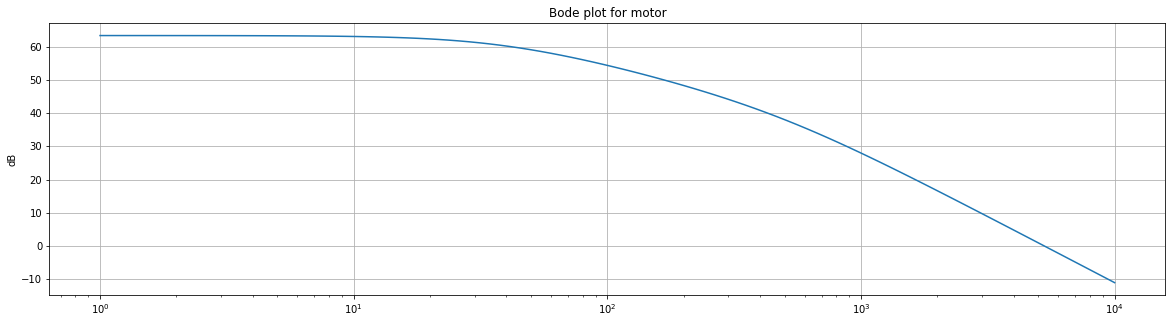

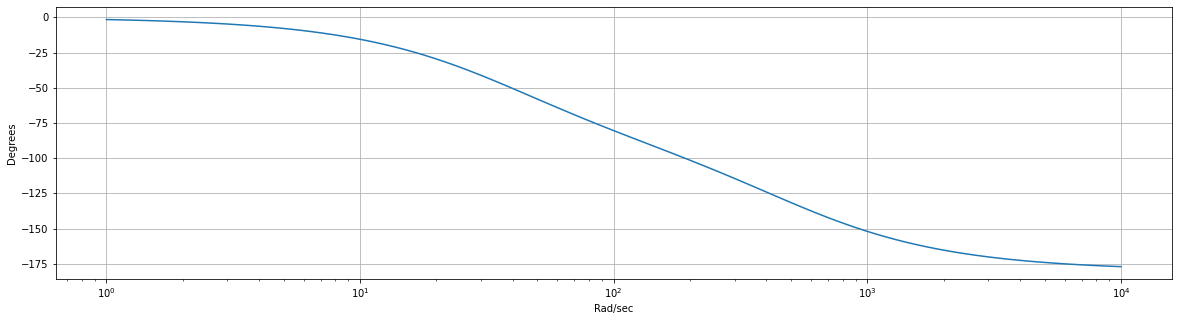

In [261]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]

J = 4.5e-9
b = 1e-8
K = 6.3e-4
R = 2.6
L = 5.0e-3

sys = signal.TransferFunction([K], [J*L, (J*R + b*L), b*R + K**2.])
w, mag, phase = signal.bode(sys)

plt.figure()
plt.title('Bode plot for motor')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.grid('on')
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

#### Step response

The motor's step response to a 1V square input:

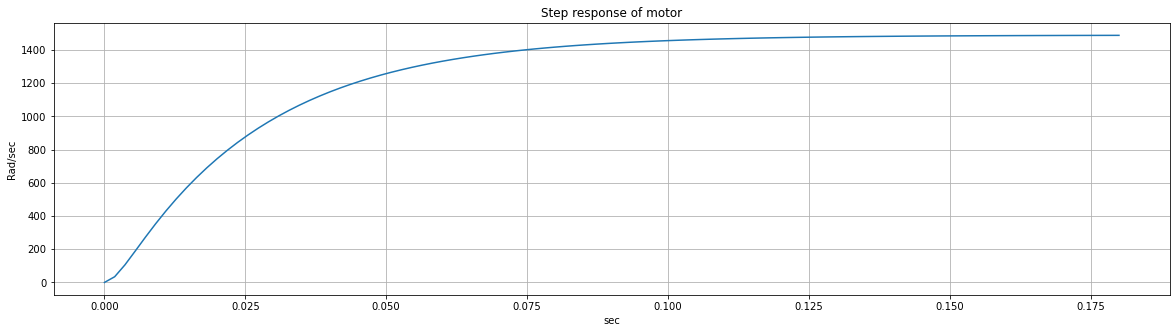

In [262]:
lti = signal.lti([K], [J*L, (J*R + b*L), b*R + K**2.])
t, y = signal.step2(lti)
plt.title('Step response of motor');plt.plot(t,y)
plt.grid('on')
plt.xlabel('sec'); plt.ylabel('Rad/sec');plt.show()

#### Making some observations

What you will notice is that the motor looks like a 2-pole lowpass filter with a cutoff frequency that is *quite high*. When we apply a square wave input to the motor, the output speed of the motor increases *effectively instantaneously from the standpoint of the pendulum*. We're about to look at the pendulum dynamics, but we'll see that the pendulum is way slower than the motor. This means that the time constants are all dominated by the lowpass characteristics of the pendulum, and by the resonance of the pendulum.

#### Simplifying the motor model

We can simplify the complicated model above to a simple lowpass filter. As shown in the plot below, this gets us a very reasonable approximation of the motor's behavior. In code, this lowpass filter looks like the following:<br><br>
`RPM[i] = (1-motor_lp)*V_control[i] + motor_lp*RPM[i-1]`<br><br>
Some experimentation shows that `motor_lp=0.95` gives a reasonable approximation. Don't forget the objective! We aren't trying to get this perfect, we're just trying to get a reasonable model for the system. The motor lowpasses the commanded RPM to the motor.

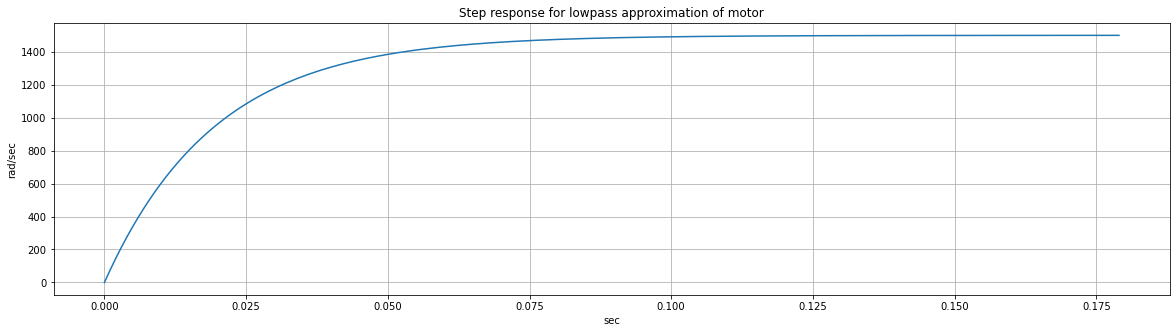

In [263]:
vcontrol = 1500 #commanded rad/sec
motor_lp = 0.95 #lowpass parameter
RPM = [0]
for i in range(1000):
    RPM.extend([(1-motor_lp)*vcontrol + motor_lp*RPM[i]])
plt.plot((numpy.arange(0, 1001)/1000.)[0:180],RPM[0:180])
plt.xlabel('sec'); plt.ylabel('rad/sec'); 
plt.grid('on')
plt.title('Step response for lowpass approximation of motor');plt.show()

## Modeling the pendulum physics

We will solve for the pendulum equation of motion by setting up a torque balance. There are three contributions to the torque on the pendulum: gravity, friction, and thrust. Thrust is always pointing in the direction that the motor is pointing, and gravity is always pointing toward the center of Earth, and friction acts opposite the direction of motion.

#### Thrust

Thrust is approximately proporitonal to the square of the rotor rotation speed. The constant of proportionality depends on lots of stuff (properties of the propeller, the fluid, etc.), but we'll just call it $K_T$ and play with it in simulation until we get a response that looks pretty good.

\begin{align}
\tau_{thrust} &= K_T \omega L
\end{align}

#### Gravity

The force from gravity is always toward the center of the Earth, so we must account for the angle of the beam in our torque calculation.

\begin{align}
\tau_g &= m g  L  \sin{\theta}
\end{align}

<figure>
    <img align="center" width="700" height="500" src="system.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

#### Friction

And the torque from friction is proportional to the rotation rate, $\dot{\theta}$:

\begin{align}
\tau_f &= K_f \dot{\theta}
\end{align}

#### Equation of motion

We know that the net torque equals the moment of inertia times the angular acceleration, as shown below:

\begin{align}
\sum \tau &= J \ddot{\theta}
\end{align}

If we assume that the mass of the beam is negligible compared to the mass of the motor, then the moment of inertia is simply $J=mL^2$. Thus:

\begin{align}
\sum \tau = m L^2  \ddot{\theta}
\end{align}

Substitute the torque expressions:

\begin{align}
\tau_{thrust} - \tau_g - \tau_f &= m\cdot L^2 \cdot \ddot{\theta}\\
K_T  \omega  L - m  g  L  \sin{\theta} - K_f \dot{\theta} &= m L^2  \ddot{\theta}
\end{align}

Solve for the angular acceleration:

\begin{align}
\ddot{\theta} &= f(\omega, \theta, \dot{\theta}) =  \frac{K_T}{mL} \omega - \frac{g}{L}\sin{\theta} - \frac{K_f}{mL^2} \dot{\theta}
\end{align}

#### Linearization

That's a nonlinear equation! For sake of deploying some standard linear analysis, let's linearize this system about $\theta= 0$ (hanging vertically):

\begin{align}
\ddot{\theta} &= f(\omega, \theta, \dot{\theta}) \approx  \frac{K_T}{mL} \omega - \frac{g}{L}\theta - \frac{K_f}{mL^2} \dot{\theta}
\end{align}

#### Pendulum Laplace transform

\begin{align}
s^2 \Theta(s) &= \frac{K_T}{mL}\Omega(s) - \frac{g}{L}\Theta(s) - s \frac{K_f}{mL^2}\Theta(s)
\end{align}

\begin{align}
s^2 \Theta(s) + \frac{g}{L}\Theta(s) + s \frac{K_f}{mL^2}\Theta(s) &= \frac{K_T}{mL}\Omega(s)
\end{align}

\begin{align}
\Theta(s)\left(s^2   + s \frac{K_f}{mL^2}+ \frac{g}{L}\right) &= \frac{K_T}{mL}\Omega(s)
\end{align}

#### Pendulum transfer function

\begin{align}
\frac{\Theta(s)}{\Omega(s)} &= \frac{\frac{K_T}{mL}}{\left(s^2   + s \frac{K_f}{mL^2}+ \frac{g}{L}\right)}
\end{align}

#### Pendulum Bode plot

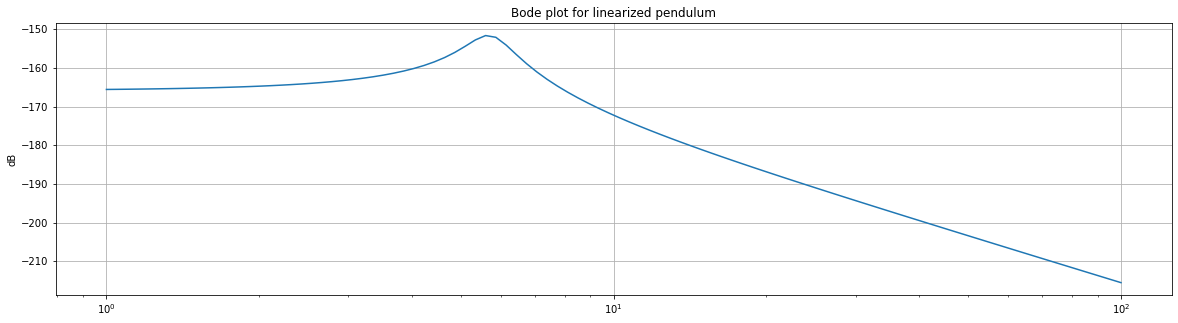

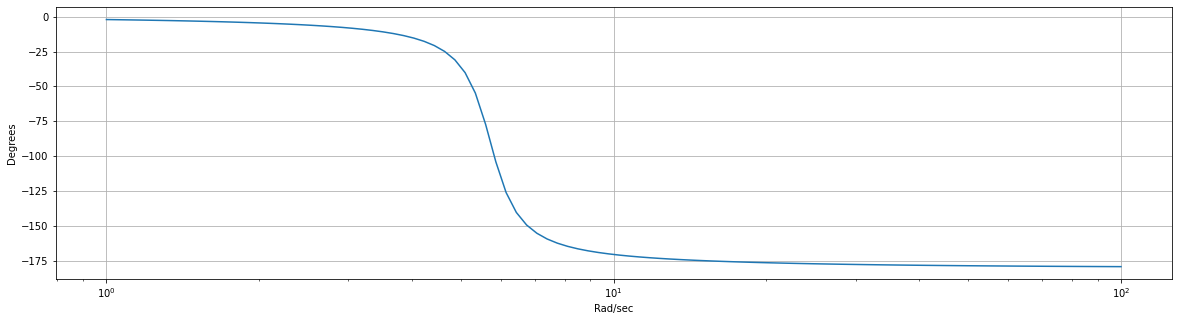

In [268]:
Kt = 5.e-10
L = 0.3
m = 0.01
g = 9.8
Kf = 1.e-3

sys2 = signal.TransferFunction([(Kt/(m*L))], [1., Kf/(m*(L**2.)), (g/L)])
w, mag, phase = signal.bode(sys2)

plt.figure()
plt.title('Bode plot for linearized pendulum')
plt.grid('on')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

Note the resonant peak at $\omega = \sqrt{\frac{g}{L}} = \sqrt{\frac{9.8}{0.3}} = 5.7$ rad/sec. Note also that the amplitude response falls of at -40db/decade after resonance. We have a 90 degree phase shift at the resonant frequency and then a 180 degree phase shift at high frequencies.

## Open-loop transfer function

Combining the two transfer functions:

\begin{align}
G(s) = \frac{\Theta(s)}{V(s)} &= \frac{K \cdot \frac{K_T}{mL}}{JLs^4 + \left[JL\frac{K_f}{mL^2} + (JR + bL)\right]s^3 + \left[JL\frac{g}{L} + (JR + bL)\frac{K_f}{mL^2} + (bR + K^2)\right]s^2 + \left[(JR + bL)\frac{g}{L} + (bR + K^2)\frac{K_f}{mL^2}\right]s + (bR + K^2)\frac{g}{L}} 
\end{align}

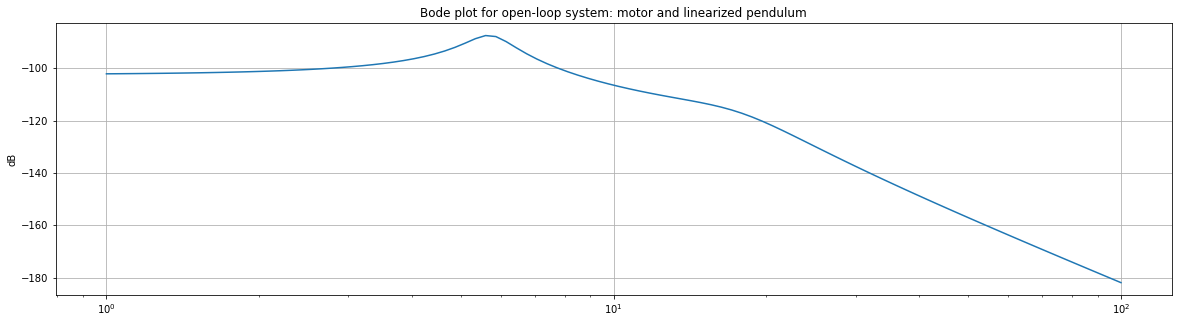

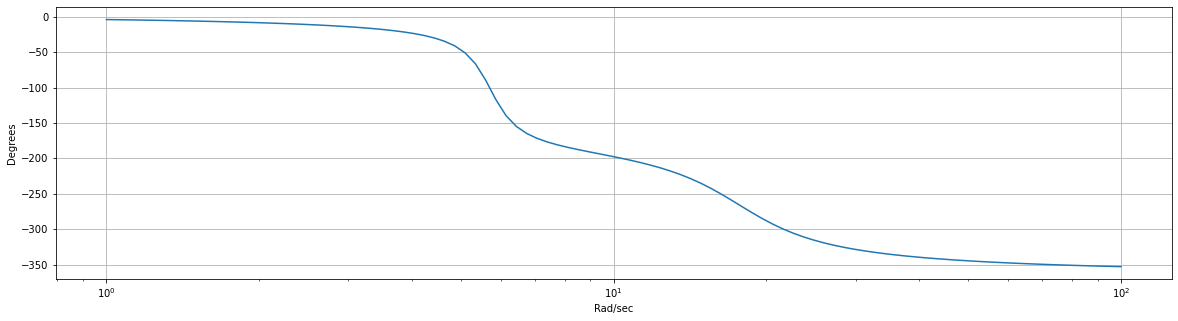

In [343]:
sys3 = signal.TransferFunction([K*(Kt/(m*L))],
                               [ J*L,
                                (J*L*(Kf/(m*L**2.))) + (J*R + b*L),
                                 J*g + (J*R + b*L)*(Kf/(m*L**2.)) + (b*R + K**2.),
                                (J*R + b*L)*(g/L) + (b*R + K**2.)*(Kf/(m*L**2.)),
                                (b*R + K**2.)*(g/L)])
w, mag, phase = signal.bode(sys3)

plt.figure()
plt.title('Bode plot for open-loop system: motor and linearized pendulum')
plt.grid('on')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

#### Open-loop observations

- Note that our open-loop system is Type 0 (no free integrators in the denominator). As such, it is able to track a step input but with a steady-state error given by $\frac{1}{1+k_p}$ where $k_p = G(s)|_{s=0}$.
- Note that the phase margin of the open-loop system is infinite because the gain is always less than 0dB, and the gain margin is approximately 90dB. The open-loop system is *stable*, but it is very slow and has a lot of steady-state error. We will increase the speed of the system by adding proportional gain, but this will start to destabilize the system by decreasing our gain margin.
- We can use a differentiator to increase the phase as we add gain.

## Building a PID controller

We are going to add a controller of the form shown below, where $K_d$ is the derivative gain, $K_p$ is the proportional gain, and $K_i$ is the integral gain. The plant physics is given by the transfer function above. The objective is to eliminate steady-state error from our system and to increase its speed (increase the magnitude of the output) without destabilizing it.

Note that the specific values for the gains will not be the same as in lab. The objective here is to see how the open-loop Bode plot changes as we add proportional, integral, and derivative terms to our PID controller.<br><br>

<figure>
    <img align="center" width="900" height="500" src="control.png" alt='missing' />
    <center><figcaption></figcaption></center>
</figure>

#### Proportional term

Let us start by adding proportional gain. This has the effect of lifting the magnitude plot to greater values without affecting the phase plot. This decreases (but does not eliminate) steady state error and increases the system response speed. But! It also decreases our gain margin! Note that the gain margin decreases as the magnitude plot increases, and eventually the system goes unstable (has a gain of 0dB at 180 degrees of phase). This results in the persistent oscillations shown below.

The Bode plot for the proportionally-compensated system below is stable, but *barely*. How far above -180 degrees is the phase plot when the gain crosses 0dB? How far below 0dB is the gain plot when the phase crosses -180? We get significant oscillation, as shown in the video.

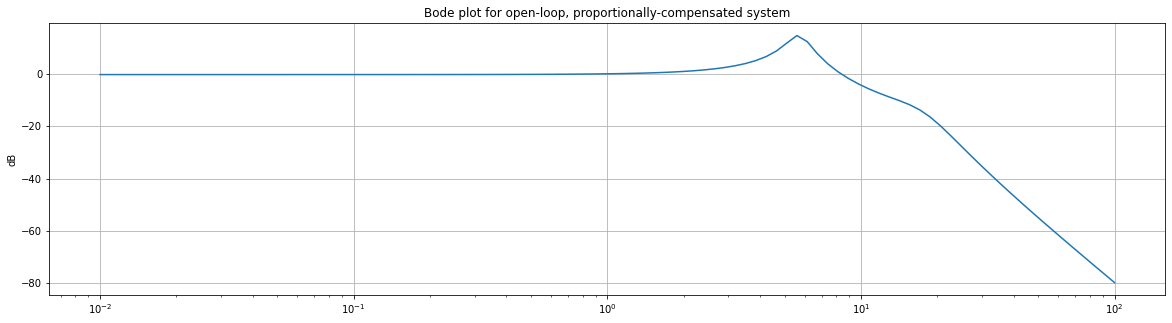

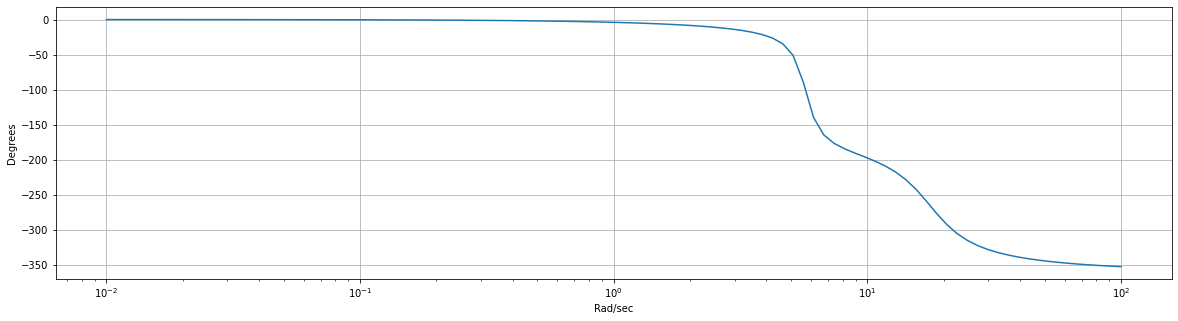

In [431]:
Kp = 129000

sys4 = signal.TransferFunction([Kp*K*(Kt/(m*L)), 0],
                               [ J*L,
                                (J*L*(Kf/(m*L**2.))) + (J*R + b*L),
                                 J*g + (J*R + b*L)*(Kf/(m*L**2.)) + (b*R + K**2.),
                                (J*R + b*L)*(g/L) + (b*R + K**2.)*(Kf/(m*L**2.)),
                                (b*R + K**2.)*(g/L), 0])
w, mag, phase = signal.bode(sys4)

plt.figure()
plt.title('Bode plot for open-loop, proportionally-compensated system')
plt.grid('on')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

<iframe width="560" height="315" src="https://www.youtube.com/embed/4oA5tnU_Et0" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

#### Derivative term

We can stabilize the system by adding a derivative term to the controller. The derivative term will add phase, improving our gain and phase margins and thus improving stability (at the cost of system speed). The first Bode plot below shows the gain/phase of the PD controller, and the second shows the controller+physics open-loop system. Note that we begin adding phase at approximately the resonant frequency of the pendulum. See the Bode plot below, and notice that the gain and phase margins are much improved.

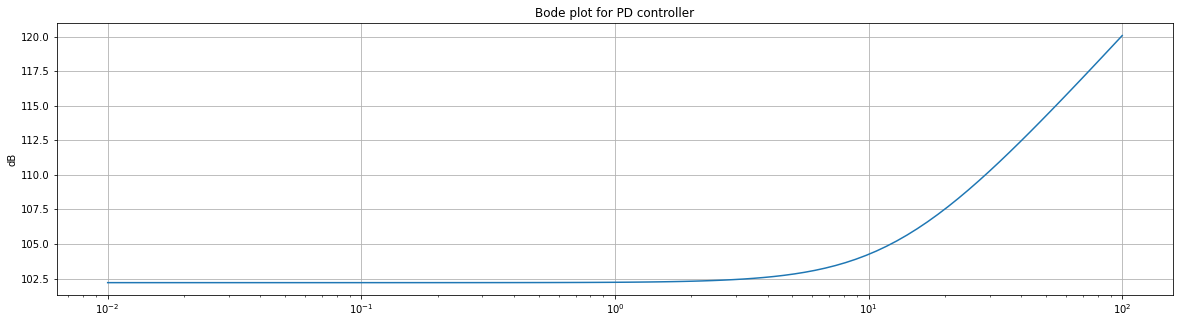

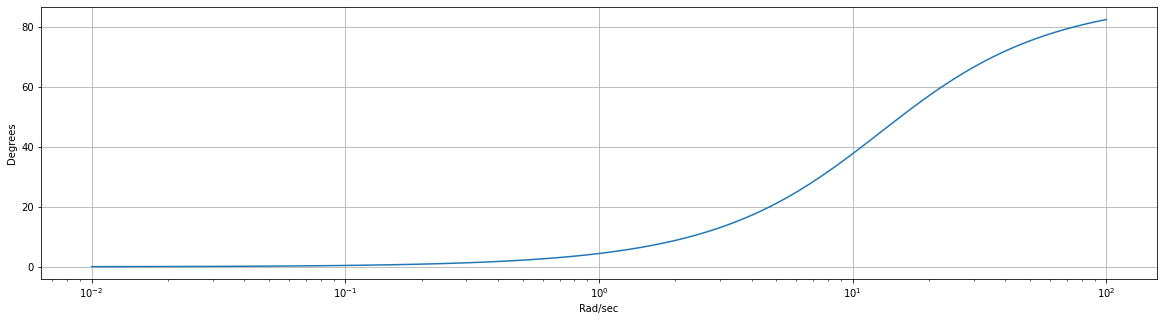

In [490]:
Kp = 129000
Kd = 10000.
Ki = 0

sys7 = signal.TransferFunction([Kd, Kp, Ki],
                               [ 1, 0])
w, mag, phase = signal.bode(sys7)

plt.figure()
plt.title('Bode plot for PD controller')
plt.grid('on')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

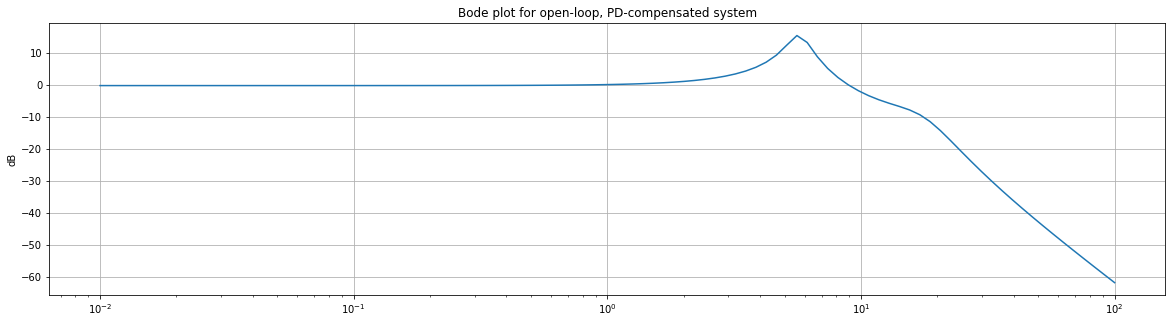

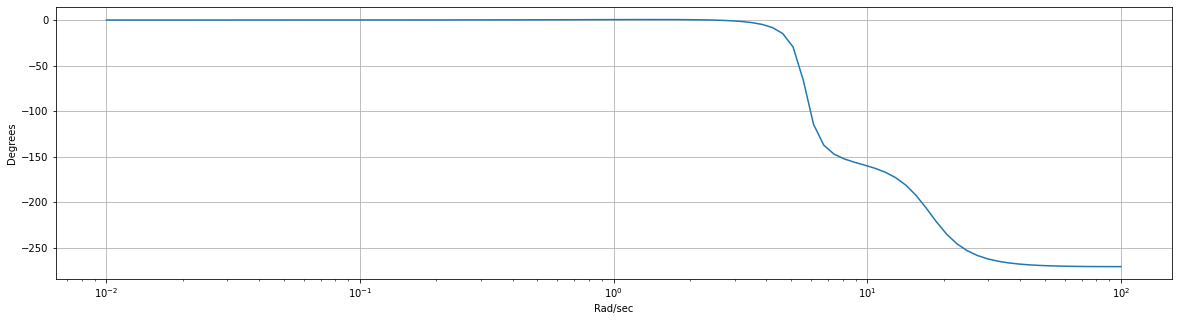

In [419]:
Kp = 129000
Kd = 10000.

sys5 = signal.TransferFunction([Kd*K*(Kt/(m*L)), Kp*K*(Kt/(m*L)), 0],
                               [ J*L,
                                (J*L*(Kf/(m*L**2.))) + (J*R + b*L),
                                 J*g + (J*R + b*L)*(Kf/(m*L**2.)) + (b*R + K**2.),
                                (J*R + b*L)*(g/L) + (b*R + K**2.)*(Kf/(m*L**2.)),
                                (b*R + K**2.)*(g/L), 0])
w, mag, phase = signal.bode(sys5)

plt.figure()
plt.title('Bode plot for open-loop, PD-compensated system')
plt.grid('on')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

#### Integral term

Finally, we must increase the system type (the number of free integrators in the open-loop transfer function) by 1 in order to eliminate steady-state error. We do this by adding an integral term to the controller. The relative magnitude of this term will be quite small because the integral term will remove phase and thus destabilize our system. This is a small term that, over time, will creep up on the target step input.

The first Bode is that of the PID controller, the second is that of the open-loop controller+physics.

In the video below, note that the integral term very slowly creeps the arm to the target hover angle.

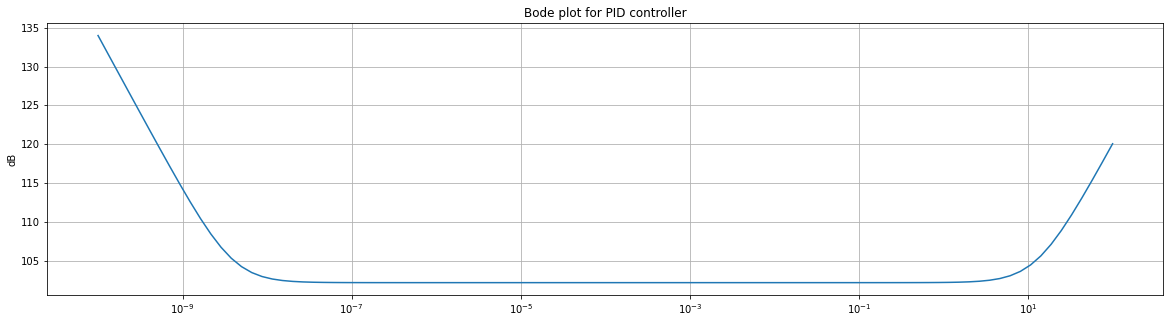

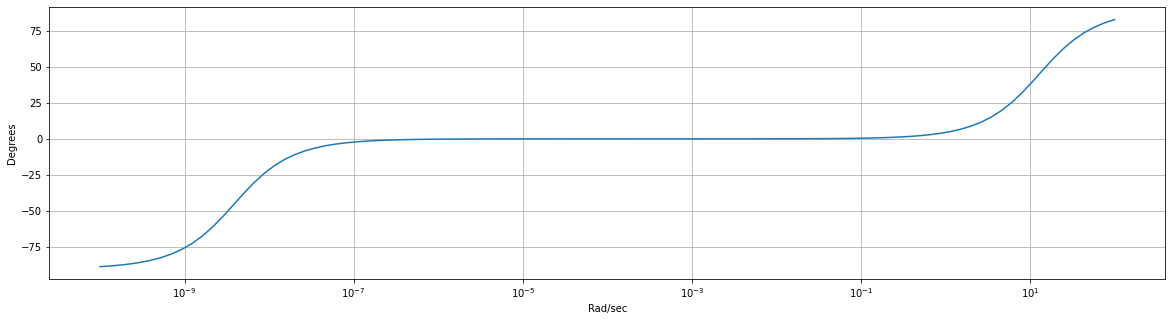

In [494]:
Kp = 129000
Kd = 10000.
Ki = 5e-4

sys8 = signal.TransferFunction([Kd, Kp, Ki],
                               [ 1, 0])
w, mag, phase = signal.bode(sys8)

plt.figure()
plt.title('Bode plot for PID controller')
plt.grid('on')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

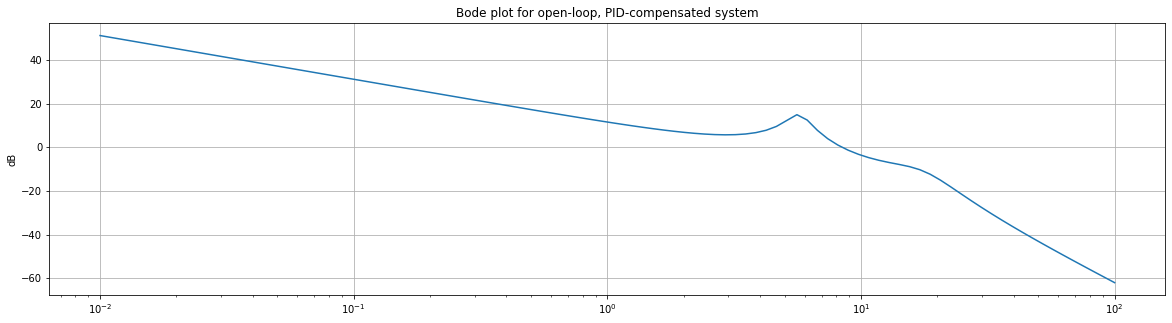

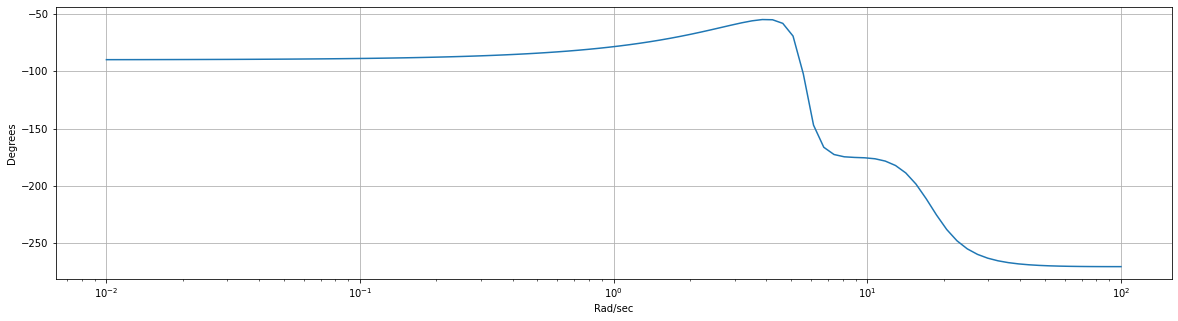

In [496]:
Kp = 129000
Kd = 10000.
Ki = 5.e-5

sys6 = signal.TransferFunction([Kd*K*(Kt/(m*L)), Kp*K*(Kt/(m*L)), Ki],
                               [ J*L,
                                (J*L*(Kf/(m*L**2.))) + (J*R + b*L),
                                 J*g + (J*R + b*L)*(Kf/(m*L**2.)) + (b*R + K**2.),
                                (J*R + b*L)*(g/L) + (b*R + K**2.)*(Kf/(m*L**2.)),
                                (b*R + K**2.)*(g/L), 0])
w, mag, phase = signal.bode(sys6)

plt.figure()
plt.title('Bode plot for open-loop, PID-compensated system')
plt.grid('on')
plt.semilogx(w, mag)    # Bode magnitude plot
plt.ylabel('dB')
plt.figure()
plt.semilogx(w, phase)  # Bode phase plot
plt.grid('on')
plt.xlabel('Rad/sec')
plt.ylabel('Degrees')
plt.show()

<iframe width="560" height="315" src="https://www.youtube.com/embed/mFCJNastS_s" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Simulating the system

The Python code below is based on [this Matlab code](https://people.ece.cornell.edu/land/courses/ece4760/labs/f2019/lab4_beam_helicopter_ADC_units.m) by Bruce.

```python
Fs = 1000.                    # sample rate (Hz)
dt = 1./Fs                    # sample time (sec)
tmax = 20.                    # max time (sec)
t = numpy.arange(0, tmax, dt) # time array

angle = numpy.zeros(len(t))     # array of hover angles (ADC units)
w  = numpy.zeros(len(t))        # array of beam rotation rates (rad/sec)
RPM = numpy.zeros(len(t))       # array of motor rates (RPM)
V_control = numpy.zeros(len(t)) # array of control inputs (V)
angle[0] = 350                  # initial beam angle (ADC units)
w[0] = 0                        # initial beam rotation rate (rad/sec)


desired_angle = 520                     # desired angle (ADC units)
error_ang = desired_angle - angle[0];   # angle error (ADC units)

Kt = 5.e-10   # thrust coefficient
L = 0.3       # beam length (m)
m = 0.01      # beam mass (kg)
g = 9.8       # gravitational constant


Kp = 200.            # proportional gain
Kd = 4000.           # derivative gain
Ki = 1/16.           # integral gain

integral_cntl = 0;   # integral accumulator
motor_lp = 0.95      # motor lowpass constant
DD = 5.e-3           # damping lowpass constant

for i in range(1, len(t)):
    
    # store previous angle error, compute current angle error
    last_error = error_ang
    error_ang = (desired_angle - angle[i-1]);
    
    # compute control input using P/I/D gains and angle error
    proportional_cntl = Kp * error_ang ;
    differential_cntl = Kd * (error_ang - last_error); 
    integral_cntl = integral_cntl + error_ang ;
    if (numpy.sign(error_ang) != numpy.sign(last_error)):
        integral_cntl = 0
    V_control[i] =  proportional_cntl + differential_cntl + Ki * integral_cntl 

    # clamp control input
    if V_control[i]<0:
        V_control[i] = 0 ;
    if V_control[i]>39999:
        V_control[i] = 39999 ;
   
    # Compute motor rate by lowpassing control input
    RPM[i] = (1-motor_lp)*V_control[i] + motor_lp*RPM[i-1];
    # Compute thrust from motor rate
    thrust = Kt * (RPM[i]**2.) ;

    # Compute lift torque
    lift_torque = thrust * L ;

    # Compute beam torque
    beam_torque = m * g *  L * numpy.cos((angle[i-1]-520)/265.) ;

    # Compute angular acceleration for beam
    w_dot = (lift_torque - beam_torque)*265 / (m * L**2.) ;

    # Euler-integrate with damping
    w[i] = w[i-1]*(1-DD) + w_dot*dt ;

    # Euler-integrate
    angle[i] = angle[i-1] + w[i]*dt ;
    
# Plot!
plt.plot(t, angle)
plt.title('1D Helicopter Simulation')
plt.plot(t, numpy.ones(len(t))*desired_angle)
plt.show()
```

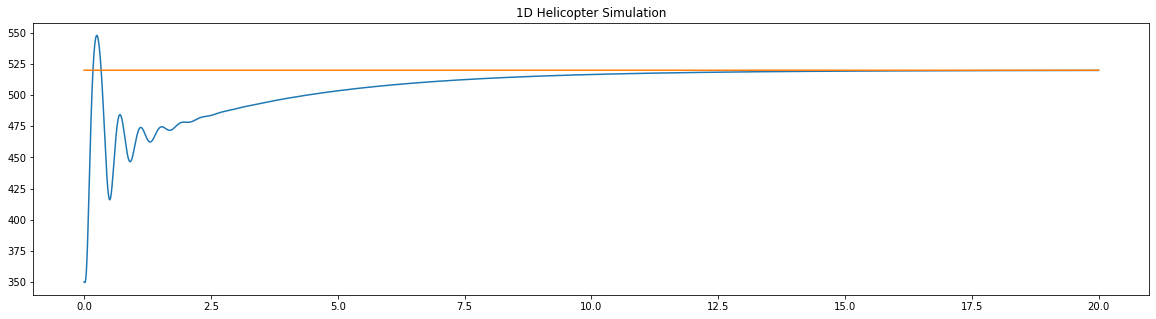

In [486]:
Fs = 1000.                    # sample rate (Hz)
dt = 1./Fs                    # sample time (sec)
tmax = 20.                    # max time (sec)
t = numpy.arange(0, tmax, dt) # time array

angle = numpy.zeros(len(t))     # array of hover angles (ADC units)
w  = numpy.zeros(len(t))        # array of beam rotation rates (rad/sec)
RPM = numpy.zeros(len(t))       # array of motor rates (RPM)
V_control = numpy.zeros(len(t)) # array of control inputs (V)
angle[0] = 350                  # initial beam angle (ADC units)
w[0] = 0                        # initial beam rotation rate (rad/sec)


desired_angle = 520                     # desired angle (ADC units)
error_ang = desired_angle - angle[0];   # angle error (ADC units)

Kt = 5.e-10   # thrust coefficient
L = 0.3       # beam length (m)
m = 0.01      # beam mass (kg)
g = 9.8       # gravitational constant


Kp = 200.            # proportional gain
Kd = 4000.           # derivative gain
Ki = 1/16.           # integral gain

integral_cntl = 0;   # integral accumulator
motor_lp = 0.95      # motor lowpass constant
DD = 5.e-3           # damping lowpass constant

for i in range(1, len(t)):
    
    # store previous angle error, compute current angle error
    last_error = error_ang
    error_ang = (desired_angle - angle[i-1]);
    
    # compute control input using P/I/D gains and angle error
    proportional_cntl = Kp * error_ang ;
    differential_cntl = Kd * (error_ang - last_error); 
    integral_cntl = integral_cntl + error_ang ;
    if (numpy.sign(error_ang) != numpy.sign(last_error)):
        integral_cntl = 0
    V_control[i] =  proportional_cntl + differential_cntl + Ki * integral_cntl 

    # clamp control input
    if V_control[i]<0:
        V_control[i] = 0 ;
    if V_control[i]>39999:
        V_control[i] = 39999 ;
   
    # Compute motor rate by lowpassing control input
    RPM[i] = (1-motor_lp)*V_control[i] + motor_lp*RPM[i-1];
    # Compute thrust from motor rate
    thrust = Kt * (RPM[i]**2.) ;

    # Compute lift torque
    lift_torque = thrust * L ;

    # Compute beam torque
    beam_torque = m * g *  L * numpy.cos((angle[i-1]-520)/265.) ;

    # Compute angular acceleration for beam
    w_dot = (lift_torque - beam_torque)*265 / (m * L**2.) ;

    # Euler-integrate with damping
    w[i] = w[i-1]*(1-DD) + w_dot*dt ;

    # Euler-integrate
    angle[i] = angle[i-1] + w[i]*dt ;
    
# Plot!
plt.plot(t, angle)
plt.title('1D Helicopter Simulation')
plt.plot(t, numpy.ones(len(t))*desired_angle)
plt.show()